# Исходные данные


В распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Предобработка данных уже сделана. 

Каждый объект в наборе данных — информация о поведении одного пользователя за месяц. 
 - сalls — количество звонков,
 - minutes — суммарная длительность звонков в минутах,
 - messages — количество sms-сообщений,
 - mb_used — израсходованный интернет-трафик в Мб,
 - is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

#  Задачи

Построить модель, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».


Модель классификации должна выбрать подходящий тариф с максимально большим значением accuracy. Доля правильных ответов должна быть не менее 0.75.

# Обзор данных

In [1]:
# импорт библиотек

import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import GridSearchCV as GSCV
from sklearn.dummy import DummyClassifier as DC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
# открываем файл

try:
    df = pd.read_csv('users_behavior.csv')
except:
      df = pd.read_csv('datasets/users_behavior.csv')

In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


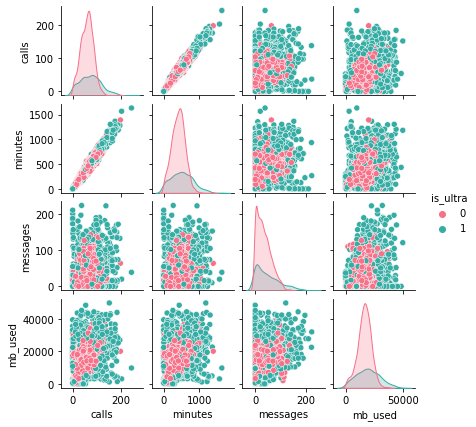

In [5]:
# проанализируем взаимосвязь и влияние параметров на целевой признак

sns.pairplot(df, hue='is_ultra', height=1.5, palette='husl')

# Построение моделей

In [6]:
# Разобьем данные на обучающую, валидационную и тестовую выборки.

# отделим признаки для предсказания и целевые признаки как 2 датасета
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

# разделим обучающую и тестовую выборки как 6:4
features_train, features_test, target_train, target_test = train_test_split(
    features, target, train_size=0.6, random_state=123)

# разделим тестовую выборку на тестовую и валидационную 1:1
features_test, features_valid, target_test, target_valid = train_test_split(
    features_test, target_test, train_size=0.5, random_state=123)

In [7]:
# проверим результат - соотношение выборок 3:1:1

print(features_train.shape)
print(features_test.shape)
print(features_valid.shape)

(1928, 4)
(643, 4)
(643, 4)


## LogisticRegression

In [8]:
algorithm = ['lbfgs', 'liblinear', 'sag', 'saga']
best_logistic = None
best_result = 0
best_solver = None

for name in algorithm:
    model = LR(max_iter=10000, random_state=123, solver=name)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = model.score(features_valid, target_valid)
    if result > best_result:
        best_result = result
        best_logistic = model
        best_solver = name

print('Accuracy лучшей модели:', best_result)
print('Алгоритм лучшей модели:', best_solver)

Accuracy лучшей модели: 0.7309486780715396
Алгоритм лучшей модели: lbfgs


##  DecisionTreeClassifier

In [9]:
# через цикл пройдем по глубине дерева от 1 до 10, где выберем глубину с лучшей accuracy

best_tree = None
best_result = 0
best_rmse = 0
for depth in range(1, 11):
    model = DTC(max_depth=depth, random_state=123, criterion='gini')
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions_valid)
    if result > best_result:
        best_result = result
        best_tree = model
        
print('Accuracy лучшей модели:', best_result)
print('Глубина лучшей модели:', depth)

Accuracy лучшей модели: 0.7962674961119751
Глубина лучшей модели: 10


## RandomForestClassifier 

In [10]:
# через цикл пройдем по кол-ву деревьев от 10 до 100, где выберем глубину с лучшей accuracy
# глубину зададим 10, т.к в предыдущей классификации при такой глубине был лучший реультат

best_forest = None
best_result = 0
for estimators in range(10, 101):
    model = RFC(n_estimators=estimators, max_depth=10, random_state=123)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions_valid)
    if result > best_result:
        best_result = result
        best_forest = model
        
print('Accuracy лучшей модели:', best_result)
print('Кол-во деревьев:', estimators)

Accuracy лучшей модели: 0.8055987558320373
Кол-во деревьев: 100


<div class="alert alert-info"> 


**Итог**

 - Из трех рассмотренных моделей самый худший результат accuracy показала Логическая регрессия - что вполне логично, т.к. в предсказаниях у нас всего два варианта ответа - 0/1. Такая задача лучше подходит для бинарного классификатора.
 - Самый высокий результат показала модель Случайного леса и кол-вом деревьев 100 и глубиной 10. Модель Дерева решений показала немного худший результат.
 - Исходя всего вышеперечисленного, будем проводить тест для модели Случайного леса

In [11]:
# Попробуем улучшить модель Случайного леса

rfc = RFC()
parametrs = {'n_estimators': range (100, 151, 10),
            'max_depth': range (10,21,2),
            'min_samples_leaf': range (1,8),
            'min_samples_split': range (2,10,2)}

gscv = GSCV(rfc, parametrs, cv=3)
gscv.fit(features_train, target_train)

gscv.best_params_

{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 100}

In [12]:
best_rfc = RFC(n_estimators=150, max_depth=10, min_samples_leaf=1, min_samples_split=6, random_state=123)
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
result = accuracy_score(target_valid, predictions_valid)
print('Accuracy лучшей модели:', result)

Accuracy лучшей модели: 0.7931570762052877


 <div class="alert alert-info"> 
 
 - Accuracy полученной модели стало существенно ниже, поэтому для предстаказния оставим предудыщую модель

# Тестовая выборка

In [13]:
# выведем итоговую лучшую модель

model = RFC(n_estimators=100, max_depth=10, random_state=123)
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
result = accuracy_score(target_valid, predictions_valid)

In [14]:
# построим прогноз на тестовой выборке и узнаем accuracy

predictions_test = best_forest.predict(features_test)
result = accuracy_score(target_test, predictions_test)

print('Accuracy тестовой выборки:', result)

Accuracy тестовой выборки: 0.8304821150855366


In [15]:
# построим матрицу ошибок

rtc_error = confusion_matrix(target_test, predictions_test)
print(rtc_error)

[[427  22]
 [ 87 107]]


<div class="alert alert-info"> 

**Вывод**
 
 - Тестовая выборка показала более высокий accuracy, чем валидационная выборка - 83% против 80%; Возможно, это связано с тем, как распределились данные по выборкам - данные тестовой выборки могли получиться более подходящими для обучения, чем данные валидационной выборки.
 - По матрице ошибок видно, что из двух вариантов ответа всегда явно превалирует один (почти в 2 раза), что также могло повлиять на результаты тестов - accuracy в таком случае будет выдавать не совсем корректный результат. 

# Оценка работы модели

In [16]:
# Для оценки работы модели проведем также сравнение с базовой моделью. 
# Если наш показатель accuracy выше нее, подобранную нами модель можно использовать в работе

dummy = DC(strategy="most_frequent", random_state=123)
dummy.fit(features_train, target_train)
score = dummy.score(features_train, target_train)

print('Базовая accuracy:', score)

Базовая accuracy: 0.691908713692946


 <div class="alert alert-info"> 

- Наш показатель accuracy выше более чем на 10%, поэтому модель Случайного леса можно использовать в работе 

# Итоги работы

 <div class="alert alert-info">  
 
 - Для обучения и предсказания выбрана модель с самым высоким показателямем accuracy. Для этой модели подобраны оптимальные гиперпараметры.
 - Проведено сравнение с базовой моделью (DummyClassifier) - наша модель показала более высокий результат и может быть введена в работу